在本章节的练习中，首先我们要完成Momentum，RMSProp，Adam三种优化方法的代码编写。在此之后，我们将重点进行BN算法的前向传播，反向传播的实现。本章我们将逐步完成：
* 编码实现Momentum算法；
* 编码实现RMSProp算法；
* 编码实现Adam算法；
* 编码实现BN前向传播；
* 编码实现BN反向传播；
* 编码实现BN全连接网络。

In [1]:
# -*- coding: utf-8 -*-
import time
import numpy as np
import matplotlib.pyplot as plt
from classifiers.chapter5 import *
from utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ 返回相对误差 """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# SGD+Momentum

使用momentum参数作为动量衰减因子，完成速度的计算后，需要将其保存在config['velocity']中。梯度检验的相对误差应该小于1e-8

In [3]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('更新权重误差: ', rel_error(next_w, expected_next_w))
print('速度误差: ', rel_error(expected_velocity, config['velocity']))

更新权重误差:  8.882347033505819e-09
速度误差:  4.269287743278663e-09


当你实现 `momentum` 更新规则后，我们使用5层隐藏层神经网络进行测试，正常情况下，加入动量方法后会比原始的SGD算法收敛得更快一些。

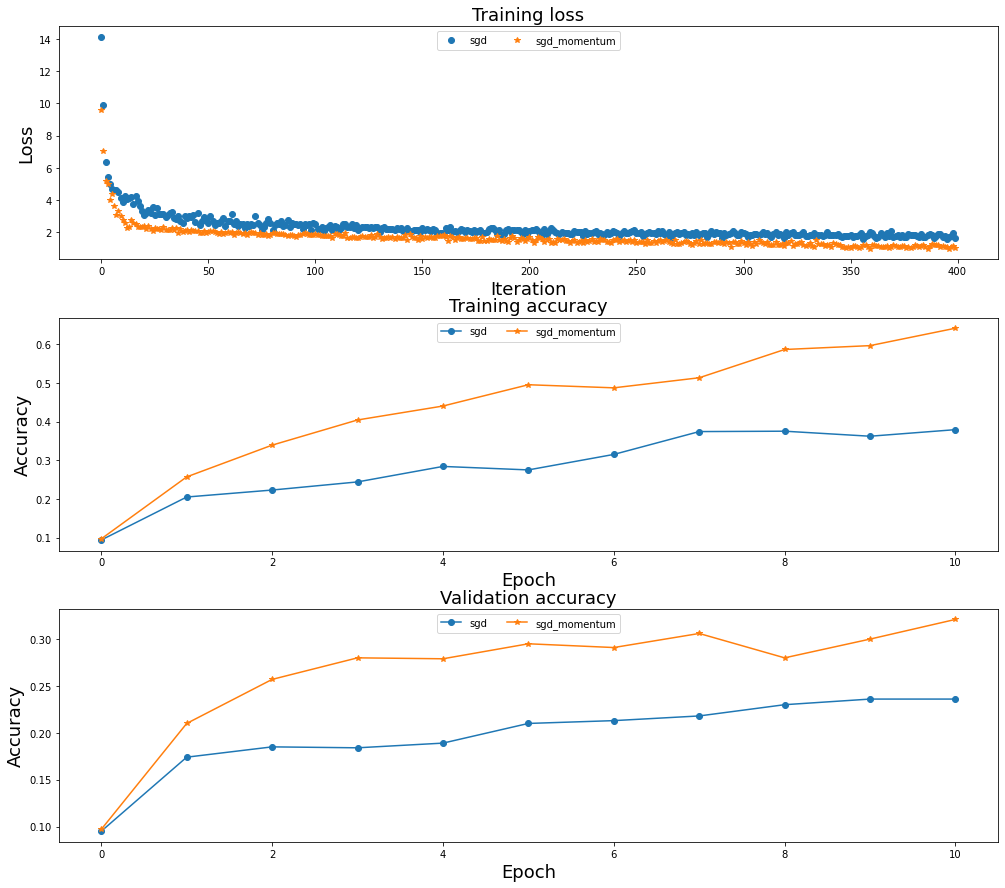

In [4]:
num_train = 4000  # 训练数据数目

# 小批量数据
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

# 训练器
trainers = {}
# 训练模型
for update_rule in ['sgd', 'sgd_momentum']:
    model = FullyConnectedNet(hidden_dims=[100, 100, 100, 100, 100], weight_scale=7e-2)

    trainer = Trainer(model, small_data,
                                    num_epochs=10, batch_size=100,
                                    update_rule=update_rule,
                                    updater_config={
                                        'learning_rate': 1e-3,
                                    },
                                    verbose=False)
    trainers[update_rule] = trainer
    trainer.train()

# 绘制图像
plt.subplot(3, 1, 1)
plt.title('Training loss',fontsize=18)
plt.xlabel('Iteration',fontsize=18)
plt.ylabel('Loss',fontsize=18)

plt.subplot(3, 1, 2)
plt.title('Training accuracy',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.subplots_adjust(left=0.08, right=0.95, wspace=0.25, hspace=0.25)
a = {'sgd':'o', 'sgd_momentum':'*'}
for update_rule, trainer in trainers.items():
    plt.subplot(3, 1, 1)
    plt.plot(trainer.loss_history, a[update_rule], label=update_rule)
    
    plt.subplot(3, 1, 2)
    plt.plot(trainer.train_acc_history, '-'+a[update_rule], label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(trainer.val_acc_history, '-'+a[update_rule], label=update_rule)
    
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

由图像可以看出，动量学习法的收敛速度更快，加快了网络的训练效率。因此在使用SGD时，加入动量的更新方式是比较好的选择。

# RMSProp and Adam

In [5]:
# 测试 RMSProp ;相对误差应该小于1e-7
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('权重更新误差: ', rel_error(expected_next_w, next_w))
print('cache 误差: ', rel_error(expected_cache, config['cache']))

权重更新误差:  9.502645229894295e-08
cache 误差:  2.6477955807156126e-09


In [6]:
# 测试 Adam 

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('权重更新误差: ', rel_error(expected_next_w, next_w))
print('v 误差: ', rel_error(expected_v, config['v']))
print('m 误差: ', rel_error(expected_m, config['m']))

权重更新误差:  1.1395691798535431e-07
v 误差:  4.208314038113071e-09
m 误差:  4.214963193114416e-09


现在我们测试SGD，momentum，RMSProp以及Adam。由于SGD，momentum已经在trainers字典中了，我们只需要实例RMSProp以及Adam网络即可。

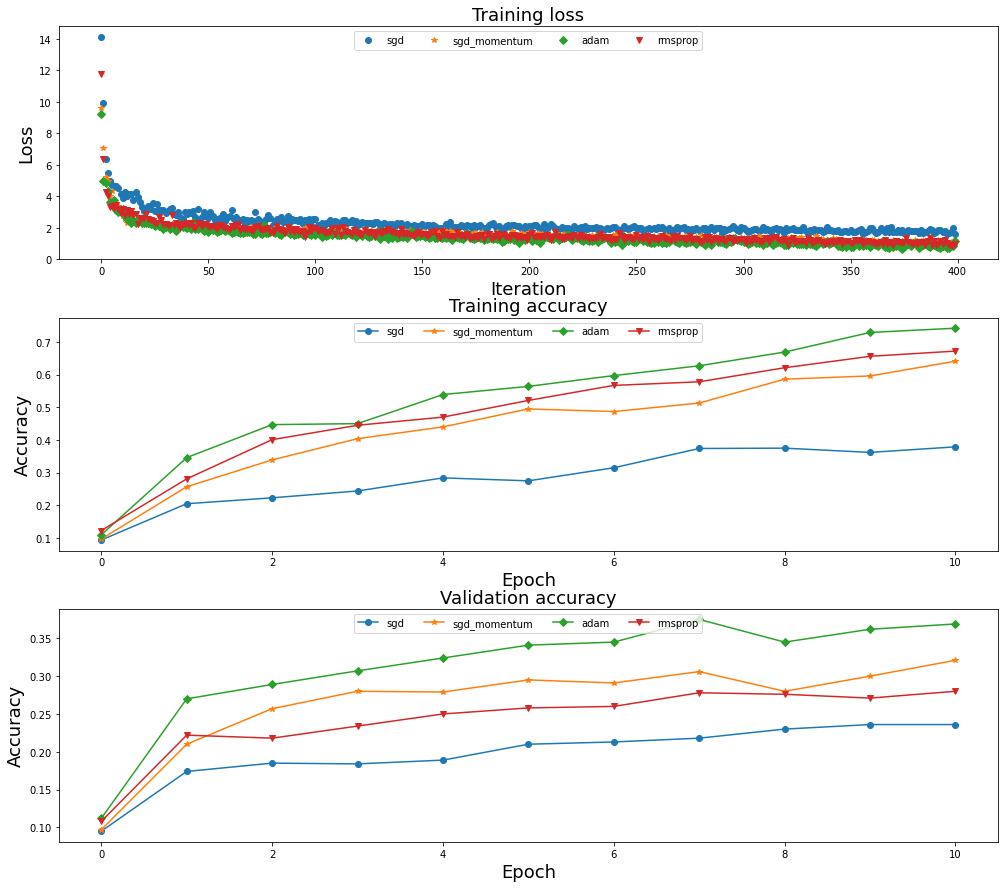

In [7]:
# 学习率
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
# 更新规则
for update_rule in ['adam', 'rmsprop']:
    model = FullyConnectedNet(hidden_dims=[100, 100, 100, 100, 100], weight_scale=7e-2)

    trainer = Trainer(model, small_data,
                                            num_epochs=10, batch_size=100,
                                    update_rule=update_rule,
                                    updater_config={
                                        'learning_rate': learning_rates[update_rule]
                                    },
                                    verbose=False)
    trainers[update_rule] = trainer
    trainer.train()

# 绘制图像
plt.subplot(3, 1, 1)
plt.title('Training loss',fontsize=18)
plt.xlabel('Iteration',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.subplot(3, 1, 2)
plt.title('Training accuracy',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)

plt.subplots_adjust(left=0.08, right=0.95, wspace=0.25, hspace=0.25)
a['adam'] = 'D'
a['rmsprop'] = 'v'
for update_rule, trainer in trainers.items():
    plt.subplot(3, 1, 1)
    plt.plot(trainer.loss_history, a[update_rule], label=update_rule)
    
    plt.subplot(3, 1, 2)
    plt.plot(trainer.train_acc_history, '-'+a[update_rule], label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(trainer.val_acc_history, '-'+a[update_rule], label=update_rule)
    
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

从图中可以看出，Adam算法的收敛效果普遍要比其他三种更新方式要快速高效些。因此在默认情况下，我们都比较推荐使用Adam算法进行网络优化。

## Batch normalization: 前向传播

In [10]:
#检验BN训练阶段前向传播的均值和方差
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('normalization之前:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# 均值应该接近零，标准差接近1
print('batch normalization之后(gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# 均值应该接近beta，标准差接近gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('batch normalization之后(随机 gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

normalization之前:
  means:  [ 18.29525763 -40.17756825 -22.86448624]
  stds:  [31.19371179 32.4207359  39.14502871]
batch normalization之后(gamma=1, beta=0)
  mean:  [ 1.57651669e-16  2.44249065e-17 -2.99760217e-17]
  std:  [0.99999999 1.         1.        ]
 batch normalization之后(随机 gamma, beta)
  means:  [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]


## Batch Normalization: 反向传播

In [13]:
# 检验BN反向传播梯度
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx 误差: ', rel_error(dx_num, dx))
print('dgamma误差: ', rel_error(da_num, dgamma))
print('dbeta 误差: ', rel_error(db_num, dbeta))

dx 误差:  4.076344212723392e-09
dgamma误差:  7.847526657072649e-12
dbeta 误差:  3.2757947066815506e-12


## Batch Normalization: 可选的反向传播

In [15]:
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx 误差: ', rel_error(dx1, dx2))
print('dgamma 误差: ', rel_error(dgamma1, dgamma2))
print('dbeta 误差: ', rel_error(dbeta1, dbeta2))
print('加速: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx 误差:  2.647976955036513e-11
dgamma 误差:  7.196843026813416e-15
dbeta 误差:  0.0
加速: 0.02x


## 使用BN的全连接网络

BN算法的全连接网络将有四种选择:
1.	深层全连接
2.	全连接+dropout
3.	全连接+BN
4.	全连接+BN+dropout


In [18]:
# 数据数目，数据维度，隐藏层1，隐藏层2，分类数目
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# 正则化系数
for reg in [0, 3.14]:
    print('检验 reg = ', reg)
    # 构建全连接网络
    model = FullyConnectedNet(hidden_dims=[H1, H2], input_dim=D, num_classes=C,
                                                        reg=reg, weight_scale=5e-2,use_batchnorm=True)
    
    loss, grads = model.loss(X, y)
    print('初始化 loss: ', loss)
    
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s 相对误差: %.2e' % (name, rel_error(grad_num, grads[name])))

检验 reg =  0
初始化 loss:  2.3946783210109417
W1 相对误差: 7.31e-04
W2 相对误差: 6.27e-06
W3 相对误差: 3.36e-10
b1 相对误差: 7.96e-09
b2 相对误差: 2.22e-03
b3 相对误差: 5.64e-11
beta1 相对误差: 4.82e-08
beta2 相对误差: 1.70e-08
gamma1 相对误差: 6.86e-08
gamma2 相对误差: 4.58e-08
检验 reg =  3.14
初始化 loss:  6.815096372845726
W1 相对误差: 1.17e-04
W2 相对误差: 4.14e-06
W3 相对误差: 2.65e-07
b1 相对误差: 1.05e-07
b2 相对误差: 1.02e-08
b3 相对误差: 2.87e-10
beta1 相对误差: 1.08e-08
beta2 相对误差: 1.01e-08
gamma1 相对误差: 1.12e-08
gamma2 相对误差: 5.58e-08


# BN性能测试

运行下列代码，测试BN算法性能

In [23]:
# 使用BN训练深层神经网络
hidden = [100, 100, 100, 100, 100]

# 小数据集
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# 权重初始化范围，标准差
weight_scale = 2e-2
# 构建网络
bn_model = FullyConnectedNet(hidden_dims=hidden, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims=hidden, weight_scale=weight_scale, use_batchnorm=False)

print('BN Network:')
# 构建BN神经网络并训练
bn_trainer = Trainer(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                updater_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_trainer.train()

print('Network:')
# 构建神经网络并训练
trainer = Trainer(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                updater_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
trainer.train()

BN Network:
(迭代 1 / 200) 损失值: 2.299534
(周期 0 / 10) 训练精度: 0.146000; 验证精度: 0.134000
(周期 1 / 10) 训练精度: 0.320000; 验证精度: 0.240000
(周期 2 / 10) 训练精度: 0.430000; 验证精度: 0.306000
(周期 3 / 10) 训练精度: 0.463000; 验证精度: 0.296000
(周期 4 / 10) 训练精度: 0.530000; 验证精度: 0.306000
(周期 5 / 10) 训练精度: 0.629000; 验证精度: 0.324000
(周期 6 / 10) 训练精度: 0.637000; 验证精度: 0.313000
(周期 7 / 10) 训练精度: 0.665000; 验证精度: 0.317000
(周期 8 / 10) 训练精度: 0.720000; 验证精度: 0.312000
(周期 9 / 10) 训练精度: 0.734000; 验证精度: 0.319000
(周期 10 / 10) 训练精度: 0.809000; 验证精度: 0.300000
Network:
(迭代 1 / 200) 损失值: 2.302481
(周期 0 / 10) 训练精度: 0.111000; 验证精度: 0.116000
(周期 1 / 10) 训练精度: 0.238000; 验证精度: 0.201000
(周期 2 / 10) 训练精度: 0.271000; 验证精度: 0.235000
(周期 3 / 10) 训练精度: 0.336000; 验证精度: 0.291000
(周期 4 / 10) 训练精度: 0.347000; 验证精度: 0.265000
(周期 5 / 10) 训练精度: 0.425000; 验证精度: 0.306000
(周期 6 / 10) 训练精度: 0.470000; 验证精度: 0.295000
(周期 7 / 10) 训练精度: 0.482000; 验证精度: 0.326000
(周期 8 / 10) 训练精度: 0.568000; 验证精度: 0.306000
(周期 9 / 10) 训练精度: 0.577000; 验证精度: 0.317000
(周期 10 / 10) 训练精度: 0.

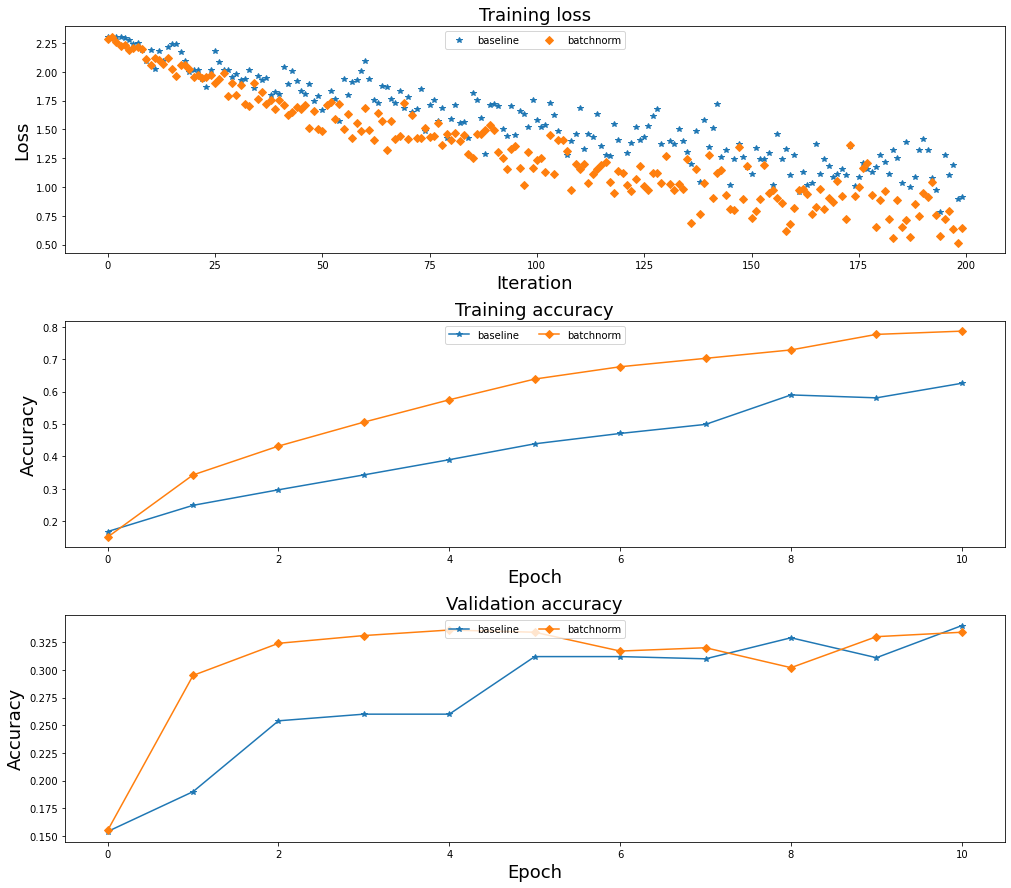

In [20]:
plt.subplots_adjust(left=0.08, right=0.95, wspace=0.25, hspace=0.3)
plt.subplot(3, 1, 1)
plt.title('Training loss',fontsize=18)
plt.xlabel('Iteration',fontsize=18)
plt.ylabel('Loss',fontsize=18)

plt.subplot(3, 1, 2)
plt.title('Training accuracy',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy',fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)

plt.subplot(3, 1, 1)
plt.plot(trainer.loss_history, '*', label='baseline')
plt.plot(bn_trainer.loss_history, 'D', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(trainer.train_acc_history, '-*', label='baseline')
plt.plot(bn_trainer.train_acc_history, '-D', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(trainer.val_acc_history, '-*', label='baseline')
plt.plot(bn_trainer.val_acc_history, '-D', label='batchnorm')
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

# BN与权重初始化比较

In [24]:
# 隐藏层神经元
hidden = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

# 构建训练器
bn_trainers = {}
trainers = {}
# 权重初始化范围，标准差
weight_scales = np.logspace(-4, 0, num=20)

t1 = time.time()

for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims=hidden, weight_scale=weight_scale, use_batchnorm=True)
    model = FullyConnectedNet(hidden_dims=hidden, weight_scale=weight_scale, use_batchnorm=False)

    bn_trainer = Trainer(bn_model, small_data,
                                    num_epochs=10, batch_size=50,
                                    update_rule='adam',
                                    updater_config={
                                        'learning_rate': 3e-3,
                                    },
                                    verbose=False, print_every=200)
    bn_trainer.train()
    bn_trainers[weight_scale] = bn_trainer

    trainer = Trainer(model, small_data,
                                    num_epochs=10, batch_size=50,
                                    update_rule='adam',
                                    updater_config={
                                        'learning_rate': 3e-3,
                                    },
                                    verbose=False, print_every=200)
    trainer.train()
    trainers[weight_scale] = trainer
    
t2 = time.time()
# 计算运行时间
print('time: %.2f s' % (t2 - t1))

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20


D:\workspace\Python\jupyter\深度学习实战范例\DLAction\classifiers\chapter5\layers.py:177: RuntimeWarning: divide by zero encountered in log
  N = x.shape[0]


Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20
time: 114.27 s


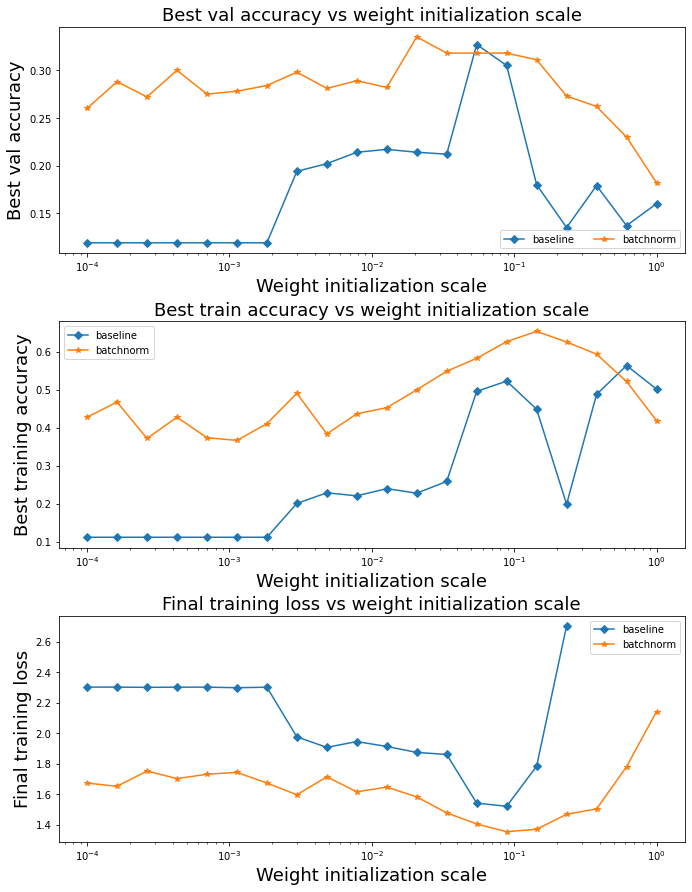

In [25]:
# 寻找最好的精度
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(trainers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_trainers[ws].train_acc_history))
    
    best_val_accs.append(max(trainers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_trainers[ws].val_acc_history))
    
    final_train_loss.append(np.mean(trainers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_trainers[ws].loss_history[-100:]))
        
plt.subplots_adjust(left=0.08, right=0.95, wspace=0.25, hspace=0.3)
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale',fontsize=18)
plt.xlabel('Weight initialization scale',fontsize=18)
plt.ylabel('Best val accuracy',fontsize=18)
plt.semilogx(weight_scales, best_val_accs, '-D', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-*', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale',fontsize=18)
plt.xlabel('Weight initialization scale',fontsize=18)
plt.ylabel('Best training accuracy',fontsize=18)
plt.semilogx(weight_scales, best_train_accs, '-D', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-*', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale',fontsize=18)
plt.xlabel('Weight initialization scale',fontsize=18)
plt.ylabel('Final training loss',fontsize=18)
plt.semilogx(weight_scales, final_train_loss, '-D', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-*', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

由图可以看出，BN算法显著地降低了权重初始化对深层网络的影响。并且在绝大多数情况下，加入BN操作都提升了网络性能。